Matteo Picciolini

# Esercitazione 12 - Esercizi 12.2 e 12.3

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D
from PIL import Image
import os

seed = 0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

2023-06-26 17:29:37.527021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 17:29:37.571365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 17:29:37.572488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 17:29:38.432032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end.

### Risoluzione

Finora ho considerato ogni campione di dati `MNIST` come un vettore 1D di lunghezza $(28x28)$. D'altra parte, in ogni cifra scritta a mano ci sono correlazioni spaziali locali tra i pixel, ma anche invarianza traslazionale, di cui si vorrebbe approfittare per migliorare l'accuratezza del modello. A tal fine, prima di tutto è necessario ridimensionare i dati di input di addestramento e di test come segue:

In [2]:
img_rows, img_cols = 28, 28 # input image dimensions (pixels) 
num_classes = 10 # output: 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape) # l'input
print('Y_train shape:', Y_train.shape) # label, ovvero gli output
print('X_test shape:', X_test.shape) # l'input
print('Y_test shape:', Y_test.shape) # label, ovvero gli output


if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('Before to_categorical: ')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('After to_categorical: ')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)
Before to_categorical: 
X_train shape:  (60000, 28, 28, 1)
Y_train shape:  (60000,)
Train samples:  60000
Test samples:  10000
After to_categorical: 
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)


A questo punto, lavorando sul codice dell'esercizio precedente, provo a migliorare le performance della rete, modificandone l'architettura facendola diventare una *Convolutional Neural Network*. Una Convolutional Neural Network (CNN), o rete neurale convoluzionale, è un tipo di rete neurale artificiale progettata per l'elaborazione e l'analisi di dati strutturati, in particolare immagini. 


A differenza delle reti neurali tradizionali, le CNN sfruttano specificamente l'operazione di convoluzione per estrarre e apprendere automaticamente le caratteristiche rilevanti dalle immagini. Questo processo di convoluzione coinvolge l'applicazione di filtri chiamati kernel su diverse regioni dell'immagine per individuare pattern, bordi, texture e altre informazioni visive significative.

Le CNN sono caratterizzate dalla presenza di strati di convoluzione seguiti da strati di pooling, che riducono progressivamente le dimensioni dell'immagine. Gli strati convoluzionali estraggono e combinano le caratteristiche locali, mentre gli strati di pooling riducono la dimensione spaziale delle caratteristiche mantenendo le informazioni più rilevanti. Successivamente, gli strati completamente connessi aggregano le caratteristiche estratte e le utilizzano per la classificazione o altre attività di elaborazione.

Utilizzo, quindi, alcuni convolutional *layers* per risolvere la *task*:
- Il layer `Conv2D` è un layer convoluzionale che esegue una convoluzione bidimensionale per estrarre alcune caratteristiche rilevanti delle immagini, come bordi e/o pattern, generando una mappa delle caratteristiche convolute.
- Il layer `MaxPooling2D` riduce l'immagine di input prendendo il valore massimo di uno dei pixel all'interno di una finestra di dimensioni fissate.
- Il layer `Dropout` disattiva alcuni neuroni durante l'addestramento per rendere più difficile l'apprendimento e rendere il modello più robusto.
- Il layer `Flatten` trasforma l'input da una forma 2D a una forma monodimensionale, consentendo l'utilizzo di altri layer di tipo Dense.

In [3]:
def create_CDNN():
    model = Sequential()
    #----------create layers-------------                                                    
    model.add(Conv2D(10, kernel_size = (5, 5),
                     activation = 'relu',
                     input_shape = input_shape))
    model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size = (4, 4)))
    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def compile_model():
    # create the model
    model = create_CDNN()
    # compile the model
    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = 'nadam',
                  metrics = ['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [4]:
my_batch_size = 32
epochs = 8

model_CDNN = compile_model()


history = model_CDNN.fit(X_train, Y_train,
                        batch_size = my_batch_size,
                        epochs = epochs,
                        verbose = 1,
                        validation_data = (X_test, Y_test)
                        )

2023-06-26 17:29:40.834252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/8
1875/1875 [==============================] - 53s 27ms/step - loss: 0.1733 - acc: 0.9488 - val_loss: 0.0873 - val_acc: 0.9840
Epoch 2/8
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0586 - acc: 0.9823 - val_loss: 0.0663 - val_acc: 0.9873
Epoch 3/8
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0440 - acc: 0.9865 - val_loss: 0.0575 - val_acc: 0.9864
Epoch 4/8
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0375 - acc: 0.9882 - val_loss: 0.0449 - val_acc: 0.9894
Epoch 5/8
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0318 - acc: 0.9900 - val_loss: 0.0359 - val_acc: 0.9913
Epoch 6/8
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0276 - acc: 0.9909 - val_loss: 0.0327 - val_acc: 0.9912
Epoch 7/8
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0242 - acc: 0.9922 - val_loss: 0.0311 - val_acc: 0.9910
Epoch 8/8
1875/1875 [==============================] - 

313/313 [==============================] - 2s 6ms/step - loss: 0.0352 - acc: 0.9884

Test loss: 0.03523992747068405
Test accuracy: 0.9883999824523926


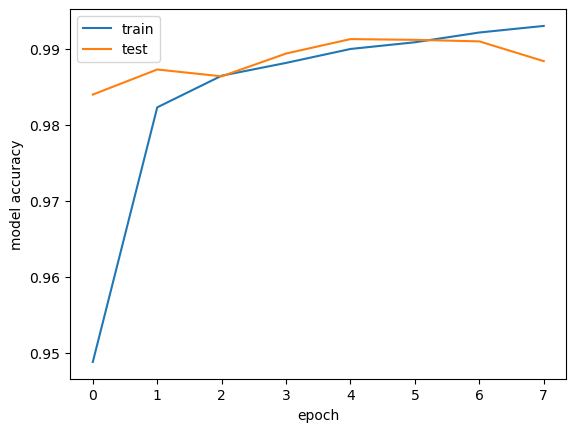

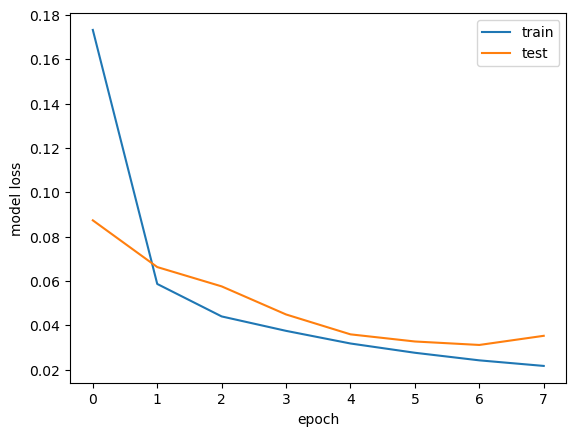

In [5]:
# evaluate model
score = model_CDNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#### Commenti
Rispetto all'esercizio precedente la *loss* e l'*accuracy* sono certametne migliorate, soprattutto confrontandole a parità di numero di epoche. La bontà del modello è, però, garantita a spese di un tempo computazionale per epoca decisamente maggiore, dell'ordine di $\sim 5$ volte il tempo di allenamento di un'epoca dell'esercizio $12.1$.

Una volta allenata la rete e fissati i parametri, quindi, si ottiene dopo $7$ epoche un valore di *loss* per il test pari $0.04$ e un valore di *accuracy* del $98,9\%$. Rispetto all'esercizio precedente, ho utilizzato un ottimizzatore diverso: `nadam`, che permette di ottenere risultati molto migliori rispetto allo stesso modello con l'ottimizzatore `adagrad`, soprattutto in termini di *loss*. Inoltre, con `nadam` ho potuto fermarmi alla settima epoca, perchè i risultati erano già ottimi, mentre con `adagrad` sono dovuto andare oltre la $10$ per ottenere comuqnue risultati peggiori di questi che sono esposti ora.

## Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

### Risoluzione
Ho usato l'applicazione `gimp` per generare alcune cifre per testare personalmente la rete. Riporto di seguito i risultati.

1/1 [==============================] - 0s 20ms/step


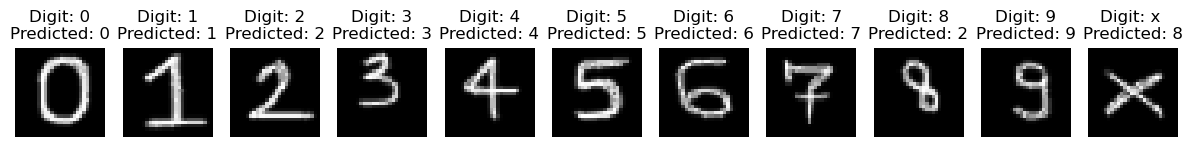

In [6]:
digit_filenames = [ "../../Data/12.3_zero.png",
                    "../../Data/12.3_one.png",
                    "../../Data/12.3_two.png",
                    "../../Data/12.3_three.png",
                    "../../Data/12.3_four.png",
                    "../../Data/12.3_five.png",
                    "../../Data/12.3_six.png",
                    "../../Data/12.3_seven.png",
                    "../../Data/12.3_eight.png",
                    "../../Data/12.3_nine.png",
                    "../../Data/12.3_x.png"]
data = []

for digit_filename in digit_filenames:
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load()
    img = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            img[i,j] = pix[j, i] / 255
    data.append(img)


predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(0, 11):
    data[i] = data[i].reshape(1, xdim, ydim, 1)
    predictions[i] = model_CDNN.predict(data[i])
    data[i] = data[i].reshape(xdim,ydim)

plt.figure(figsize = (15, 4))
for i in range(11):    
    ax = plt.subplot(1, 11, i + 1)    
    plt.imshow(data[i], cmap = 'gray')
    if i != 10:
        plt.title("Digit: "+ str(i) + "\nPredicted: {}".format(np.argmax(predictions[i])))
    else:
        plt.title("Digit: x \nPredicted: {}".format(np.argmax(predictions[i])))
    plt.axis('off') 


#### Commenti
I risultati mostrano un'ottimo accordo. L'unica cifra che viene predetta in maniera errata è la cifra $8$, che ho volutamente scritto leggermente ruotata per testare l'efficacia della rete. Il limite della rete è, evidentemente, proprio questo. In ogni caso, ho provato anche a scrivere alcune cifre con tratti non usuali (come, per esempio,  il $7$) o leggermente traslate (come il $3$), per testare la risposta della rete. La rete è stata, però, in grado di riconoscere ugualmente queste cifra. Trovo interessante che lo stesso modello con l'ottimizzatore `adagrad` restituisse predizioni di queste cifre scritte da me sbagliate, nonostante l'*accuray* coi dati di *test* fosse di circa il $95\%$.

Ho voluto anche "ingannare" la rete provando a scrivere un simbolo che non corrisponde a nessuna cifra. Il simbolo che ho utilizzato è "x", e trovo curioso che la predizione della rete sia proprio $8$, perchè è l'unica cifra con un pattern simile (il centro della cifra $8$ è simile a una "x"). Questo significa che la rete ha riconoscituo quel pattern e ha assunto che si trattasse di un $8$.